# First Task: Data understanding

We have two datasets to analyze:
- **cyclists.csv**: contains information about all the cyclists;
- **races.csv**: contains information about all the cyclism races.



### Import of the needed libraries and the dataset

In the following, we import all the main libraries needed to this project and we read the .cvs files that contin the data. The data are assigned to Pandas dataframe with the name of cyclists and races.

In [190]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os

from collections import defaultdict
from scipy.stats import pearsonr

cyclists = pd.read_csv('./dataset/cyclists.csv')
races = pd.read_csv('./dataset/races.csv')

## Assessing Data Quality

### Cyclists dataset

We begin the understanding of our data showing the first five rows of the cyclists dataset and general information about the values (*Non-Null count* and *Dtype*). Any type casting will be handled in Task 2 as part of data transformation: for now, we only give an overview of raw data to understand with what we are handling with.

It is composed by 6 attributes:
1. **_url**: identifier for the cyclist;
2. **name**: his full name;
3. **birth_year**: his year of birth;
4. **weight**: his weight;
5. **height**: his height;
6. **nationality**: his nationality.

In [191]:
cyclists.head()

_url                  name  birth_year  weight  height  \
0           bruno-surra          Bruno  Surra      1964.0     NaN     NaN   
1            gerard-rue           Gérard  Rué      1965.0    74.0   182.0   
2              jan-maas             Jan  Maas      1996.0    69.0   189.0   
3  nathan-van-hooydonck  Nathan Van Hooydonck      1995.0    78.0   192.0   
4      jose-felix-parra     José Félix  Parra      1997.0    55.0   171.0   

   nationality  
0        Italy  
1       France  
2  Netherlands  
3      Belgium  
4        Spain

In [192]:
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


#### Overview about duplicated rows, null and non-plausible values

Before focusing on the values themselves, we show that there aren't duplicated rows that could influence further studies.

In [193]:
print(f"Number of duplicated rows in cyclists dataset: {cyclists.duplicated().sum()}")

Number of duplicated rows in cyclists dataset: 0


As printed below, we can notice that *_url* and *name* entry have no null value, *birth_year* and *nationality* have very few of them while *weight* and *height* have half being null. 
More precisely:

In [194]:
cyclists_null = cyclists.isnull().sum()
print("Number of null values in each column:\n")
print(cyclists_null)

Number of null values in each column:

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64


We use the **.describe()** method to get some high-level statistics (concerning onfly of the numerical entries by definition of the method).

In [195]:
cyclists.describe()

birth_year       weight       height
count  6121.000000  3078.000000  3143.000000
mean   1974.071884    68.658739   179.815145
std      15.535834     6.348183     6.443447
min    1933.000000    48.000000   154.000000
25%    1962.000000    64.000000   175.000000
50%    1974.000000    69.000000   180.000000
75%    1987.000000    73.000000   184.000000
max    2004.000000    94.000000   204.000000

We also check if not-plausible values are present.

In [196]:
#Invalid birth year: before 1920 or after 2010
invalid_birth_year = cyclists[cyclists['birth_year'] < 1920 | (cyclists['birth_year'] > 2010)]
print(f"Number of invalid birth_year: {len(invalid_birth_year)}")

#Invalid height: less than 100 cm or over 210 cm
invalid_height = cyclists[((cyclists['height'] < 100) | (cyclists['height'] > 210)) & (cyclists['height'] != -1)]
print(f"Number of invalid height: {len(invalid_height)}")

#Invalid weight: less than 40 kg or over 120 kg
invalid_weight = cyclists[((cyclists['weight'] < 40) | (cyclists['weight'] > 120)) & (cyclists['weight'] != -1)]
print(f"Number of invalid weight: {len(invalid_weight)}")


Number of invalid birth_year: 0
Number of invalid height: 0
Number of invalid weight: 0


To conclude a general view about the cyclist dataset, we show the heatmap of the correlation matrix when we can see the clear and obvious correlation between height and weight.

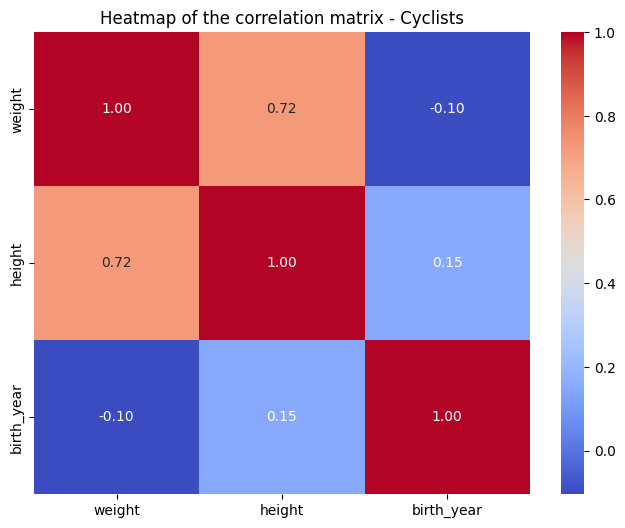

In [197]:
correlation_matrix_cyclists = cyclists[['weight', 'height', 'birth_year']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_cyclists, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of the correlation matrix - Cyclists')
plt.show()

### Races dataset

Also for this dataset, we explain the attributes it is composed by showing also the first 5 rows and giving general information about its values (*Non-null count* and *Dtype*). Any type casting, for the same reason as above, is handled in Task 2.

The races dataset is composed by the following 18 attributes:

1. **_url**: identifier for the race, typically includes the race name, year and eventually stage;
2. **name**: the official name of the race;
3. **points**: points assigned to the race, indicating its prestige or importance;
4. **uci_points**: alternative points assigned based on UCI rankings;
5. **length**: the total distance of the race, usually in meters;
6. **climb_total**: the total meters climbed during the race, indicating elevation difficulty;
7. **profile**: the race's terrain profile, such as flat, hilly, mountainous;
8. **startlist_quality**: the quality or strength of the participants in the race;
9. **average_temperature**: the average temperature during the race in degrees Celsius;
10. **date**: the date on which the race took place with YY-MM-DD HH-MM-SS format;
11. **position**: the final position or ranking of a specific cyclist in the race;
12. **cyclist**: the unique identifier for the cyclist (*_url* attribute in the cyclists table);
13. **cyclist_age**: the age of the cyclist during the race;
14. **is_tarmac**: indicates if the race was held on tarmac surfaces;
15. **is_cobbled**: indicates if the race featured cobbled sections;
16. **is_gravel**: indicates if the race included gravel sections;
17. **cyclist_team**: the team the cyclist was part of during the race;
18. **delta**: the time difference in seconds between the cyclist and the race winner.

In [198]:
races.head()

_url            name  points  uci_points    length  \
0  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
1  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
2  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
3  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
4  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   

   climb_total  profile  startlist_quality  average_temperature  \
0       1101.0      1.0               1241                  NaN   
1       1101.0      1.0               1241                  NaN   
2       1101.0      1.0               1241                  NaN   
3       1101.0      1.0               1241                  NaN   
4       1101.0      1.0               1241                  NaN   

                  date  position           cyclist  cyclist_age  is_tarmac  \
0  1978-07-05 04:02:24         0        sean-kelly         22.0       True   
1  1978-07-05 04:02:24         1  gerrie-knetemann         27.0       True   
2  1978-07-05 04:02:24         2    rene-bittinger         24.0       True   
3  1978-07-05 04:02:24         3    joseph-bruyere         30.0       True   
4  1978-07-05 04:02:24         4  sven-ake-nilsson         27.0       True   

   is_cobbled  is_gravel                          cyclist_team  delta  
0       False      False  vini-ricordi-pinarello-sidermec-1986    0.0  
1       False      False                           norway-1987    0.0  
2       False      False                                   NaN    0.0  
3       False      False              navigare-blue-storm-1993    0.0  
4       False      False                            spain-1991    0.0

In [199]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

#### Overview about duplicated rows, null and non-plausible values

Also in this dataset, there aren't duplicated rows.

In [200]:
print(f"Number of duplicated rows in races dataset: {races.duplicated().sum()}")

Number of duplicated rows in races dataset: 0


For what concerns null values, more than half of *uci_points* and *average_temperature* values are null, while *climb_total*, *profile* and *cyclist_team* have a concerning number. All the other entry have almost all non-null values. 

More precisely: 

In [201]:
races_null = races.isnull().sum()
print("Number of null values in each column:\n")
print(races_null)

Number of null values in each column:

_url                        0
name                        0
points                    477
uci_points             338779
length                      0
climb_total            147045
profile                148194
startlist_quality           0
average_temperature    559932
date                        0
position                    0
cyclist                     0
cyclist_age               113
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64


Below, the *.describe()* method outcome of high-level statistics for the numerical entries.

In [202]:
races.describe()

points     uci_points         length    climb_total  \
count  589388.000000  251086.000000  589865.000000  442820.000000   
mean       89.221635      74.601547  166776.180584    2330.469215   
std        54.435330     100.947962   64545.605664    1375.710722   
min        18.000000       6.000000    1000.000000       2.000000   
25%        50.000000      16.000000  152500.000000    1309.000000   
50%        80.000000      60.000000  178200.000000    2255.000000   
75%       100.000000     100.000000  203500.000000    3273.000000   
max       350.000000     800.000000  338000.000000    6974.000000   

             profile  startlist_quality  average_temperature       position  \
count  441671.000000      589865.000000         29933.000000  589865.000000   
mean        2.611611        1101.161178            21.731768      74.219491   
std         1.491741         380.586928             5.884761      48.404023   
min         1.000000         115.000000            10.000000       0.000000   
25%         1.000000         844.000000            17.000000      32.000000   
50%         2.000000         988.000000            22.000000      70.000000   
75%         4.000000        1309.000000            26.000000     112.000000   
max         5.000000        2047.000000            36.000000     209.000000   

         cyclist_age          delta  
count  589752.000000  589865.000000  
mean       28.486208     418.292794  
std         3.855631     842.961596  
min        13.000000   -6906.000000  
25%        26.000000      10.000000  
50%        28.000000     156.000000  
75%        31.000000     624.000000  
max        56.000000   61547.000000

We conclude this preliminary analysis checking if non-plausible values are present.

In [203]:
#Invalid points and uci points: negative number
invalid_points = races[races['points'] < 0]
print(f"Number of invalid points: {len(invalid_points)}")
invalid_uci_points = races[races['uci_points'] < 0]
print(f"Number of invalid uci_points: {len(invalid_uci_points)}")

#Invalid length: negative length or over 10.000 km
invalid_length = races[(races['length'] < 0) | (races['length'] > 10000)]
print(f"Number of invalid length: {len(invalid_length)}")

#Invalid altitude difference: negative or over 2.000 km
invalid_climb_total = races[(races['climb_total'] < 0) | (races['climb_total'] > 2000)]
print(f"Number of invalid climb_total: {len(invalid_climb_total)}")

#Invalid age of participation: less than 17 or more than 45
invalid_ages = races[((races['cyclist_age'] < 17) | (races['cyclist_age'] > 45))]
print(f"Number of invalid cyclist_age: {len(invalid_ages)}")

Number of invalid points: 0
Number of invalid uci_points: 0
Number of invalid length: 565251
Number of invalid climb_total: 253740
Number of invalid cyclist_age: 2


The interested two rows outlighted by the last check are printed below. For now, we decided not to take that.

In [204]:
races[((races['cyclist_age'] < 17) | (races['cyclist_age'] > 45))].head()

_url                            name  points  \
114525  vuelta-a-espana/1996/stage-1                 Vuelta a España    80.0   
294489     san-sebastian/2001/result  Clasica Ciclista San Sebastian   225.0   

        uci_points    length  climb_total  profile  startlist_quality  \
114525         NaN  162000.0        862.0      NaN                988   
294489         NaN  227000.0          NaN      2.0               1048   

        average_temperature                 date  position  \
114525                  NaN  1996-09-07 03:52:27       129   
294489                  NaN  2001-08-11 05:28:57        91   

                       cyclist  cyclist_age  is_tarmac  is_cobbled  is_gravel  \
114525  jose-azevedo-goncalves         56.0       True       False      False   
294489           plamen-stanev         13.0      False       False      False   

       cyclist_team  delta  
114525          NaN    0.0  
294489          NaN  663.0

To conclude a general view about the races dataset, we show the heatmap of the correlation_matrix. The only pair of numeric variables that presents a significant linear relationship is 'points' and 'uci_points'. Another small note of merit is for the pair 'length'-'climb-total' that reaches a value of 0.5.

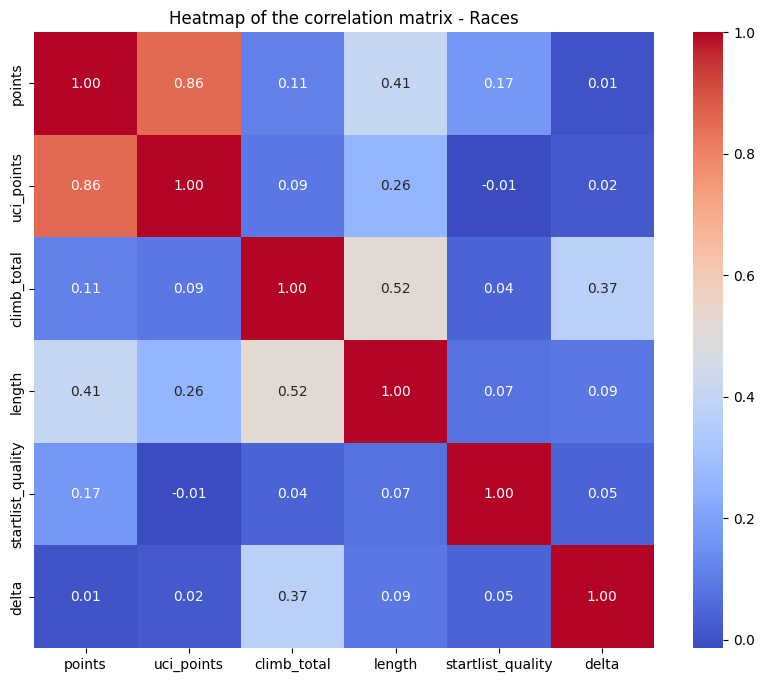

In [205]:
correlation_matrix = races[['points', 'uci_points', 'climb_total', 'length', 'startlist_quality', 'delta']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of the correlation matrix - Races')
plt.show()


## Data Distribution

In this subtask, we show and analyze the distribution of the attributes in the datasets.

### Cyclist dataset

Obviously, we don't show the *name* and *_url* one since the x-axis should contain more than 6000 values with all frequency = 1. 

#### '*birth_year*' distribution
The distribution of birth years follows our expectations, with most cyclists born between 1960 and 1990.

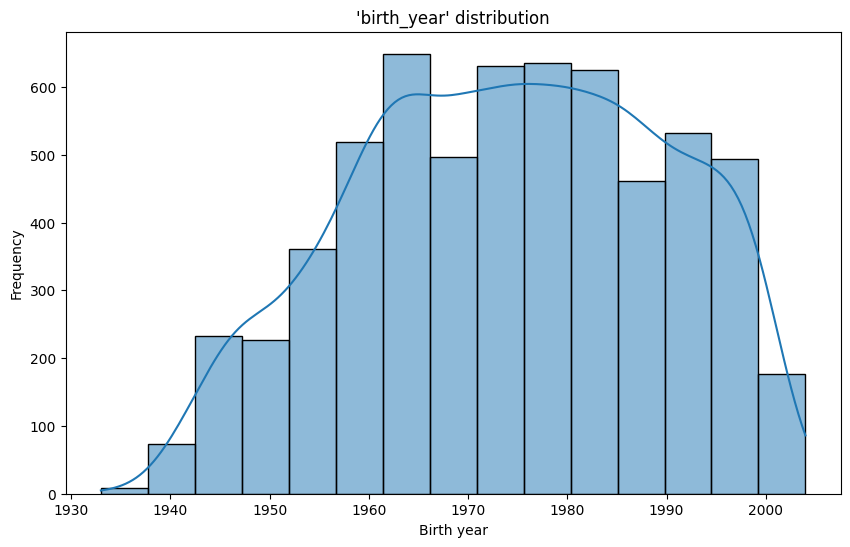

In [206]:
plt.figure(figsize=(10, 6))
sns.histplot(cyclists['birth_year'],bins=15, kde=True)
plt.title('\'birth_year\' distribution')
plt.xlabel('Birth year')
plt.ylabel('Frequency')
plt.show()

#### '*weight*' and '*height*' distribution
Both height and weight show peaks, indicating that most cyclists are around 1.80 meters tall and 70 kg weighted.

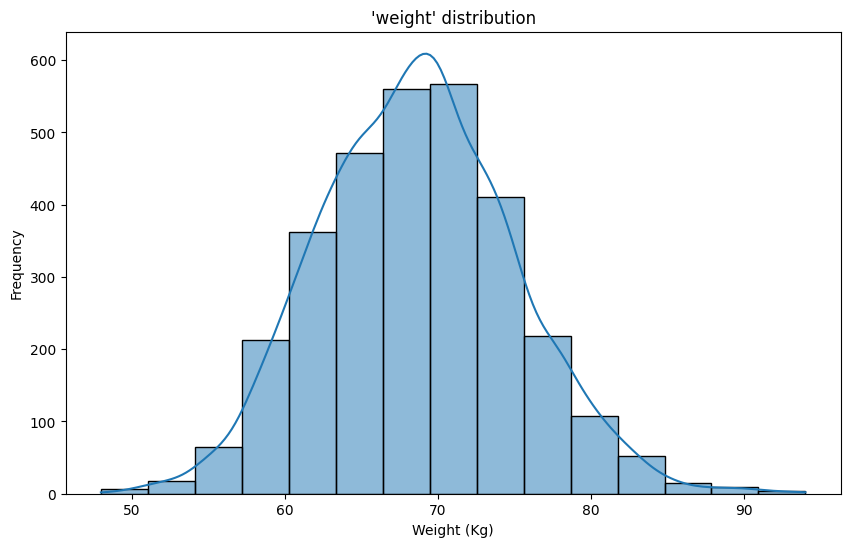

In [207]:
plt.figure(figsize=(10, 6))
sns.histplot(cyclists['weight'], bins=15, kde=True)
plt.title('\'weight\' distribution')
plt.xlabel('Weight (Kg)')
plt.ylabel('Frequency')
plt.show()

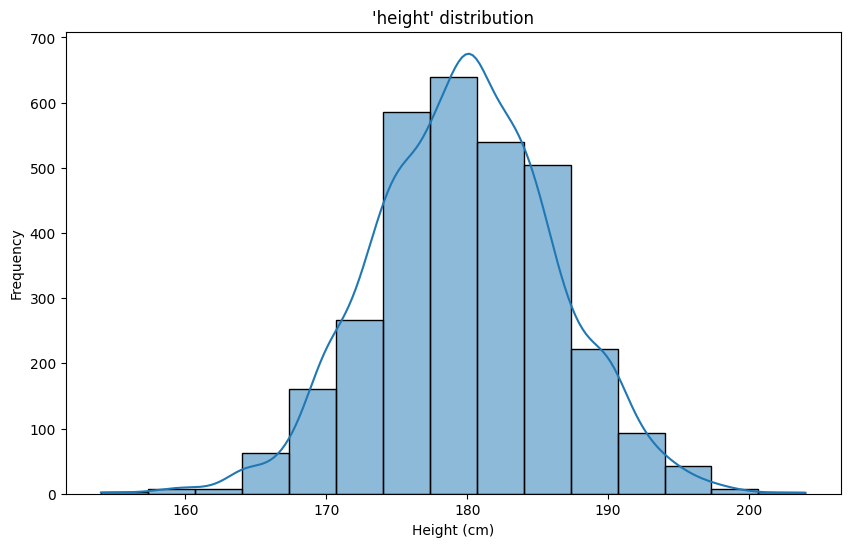

In [208]:
plt.figure(figsize=(10, 6))
sns.histplot(cyclists['height'], bins=15, kde=True)
plt.title('\'height\' distribution')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.show()

#### '*nationality*' distribution

Showing the distribution is possible also for categorical attributes.
For *nationality*, we show a distribution for all of them and then a more precisely one for the top-20 ones.


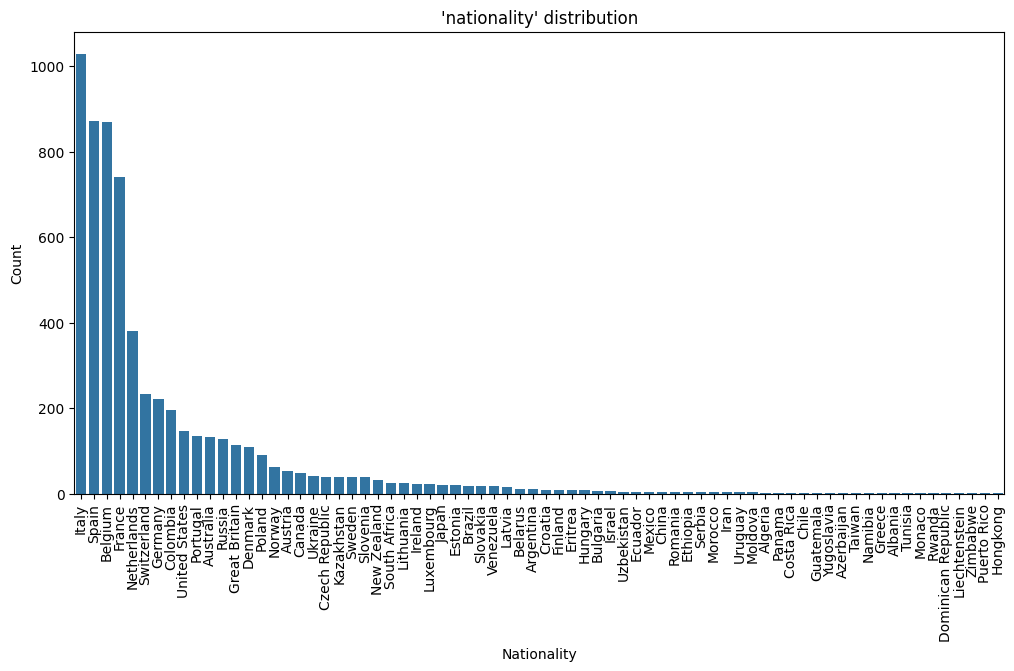

In [209]:
plt.figure(figsize=(12, 6))
sns.countplot(data=cyclists, x='nationality', order=cyclists['nationality'].value_counts().index)
plt.title('\'nationality\' distribution')
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

The top 20 nationalities, which account for 91.995% of the total values.
It's also possible to notice that the italian cyclists are the majority with 16.78%:


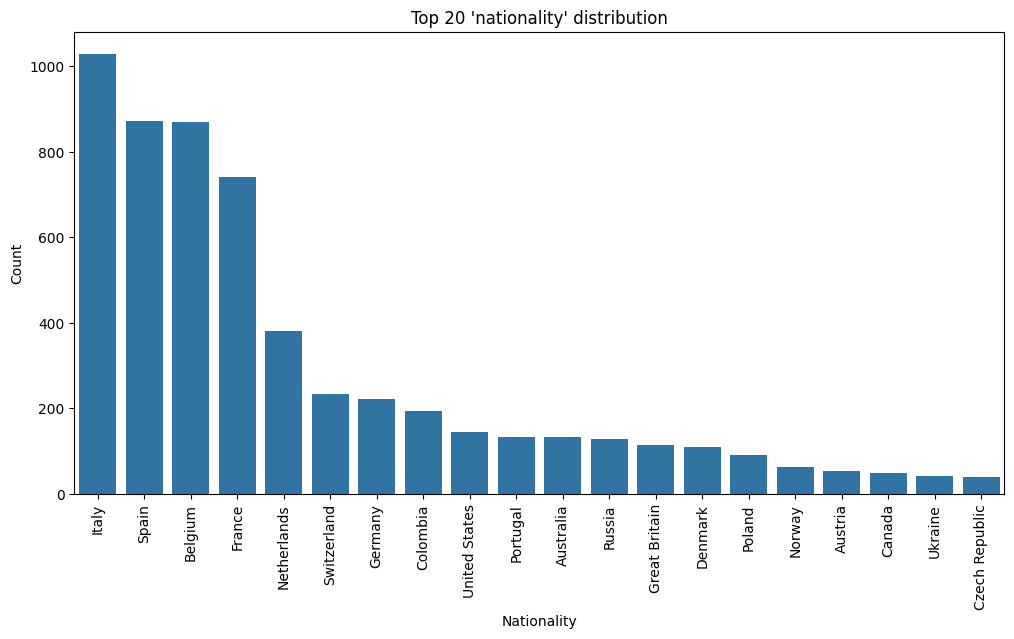

In [210]:
nationality_percentual = cyclists['nationality'].value_counts().head(20).sum() / len(cyclists) * 100
print(f"The top 20 nationalities, which account for {round(nationality_percentual,3)}% of the total values.")

italian_percentual = cyclists[cyclists['nationality'] == 'Italy'].shape[0] / len(cyclists) * 100
print(f"It's also possible to notice that the italian cyclists are the majority with {round(italian_percentual,2)}%:")

plt.figure(figsize=(12, 6))
sns.countplot(data=cyclists, x='nationality', order=cyclists['nationality'].value_counts().head(20).index)
plt.title('Top 20 \'nationality\' distribution')
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

### Races dataset

For the same reason as *name* in cyclists, we don't plot *_url*, *cyclist* and *cyclist_team* in races. 

#### '*name*' distribution

We plot first all names, then we focus on the first 10.

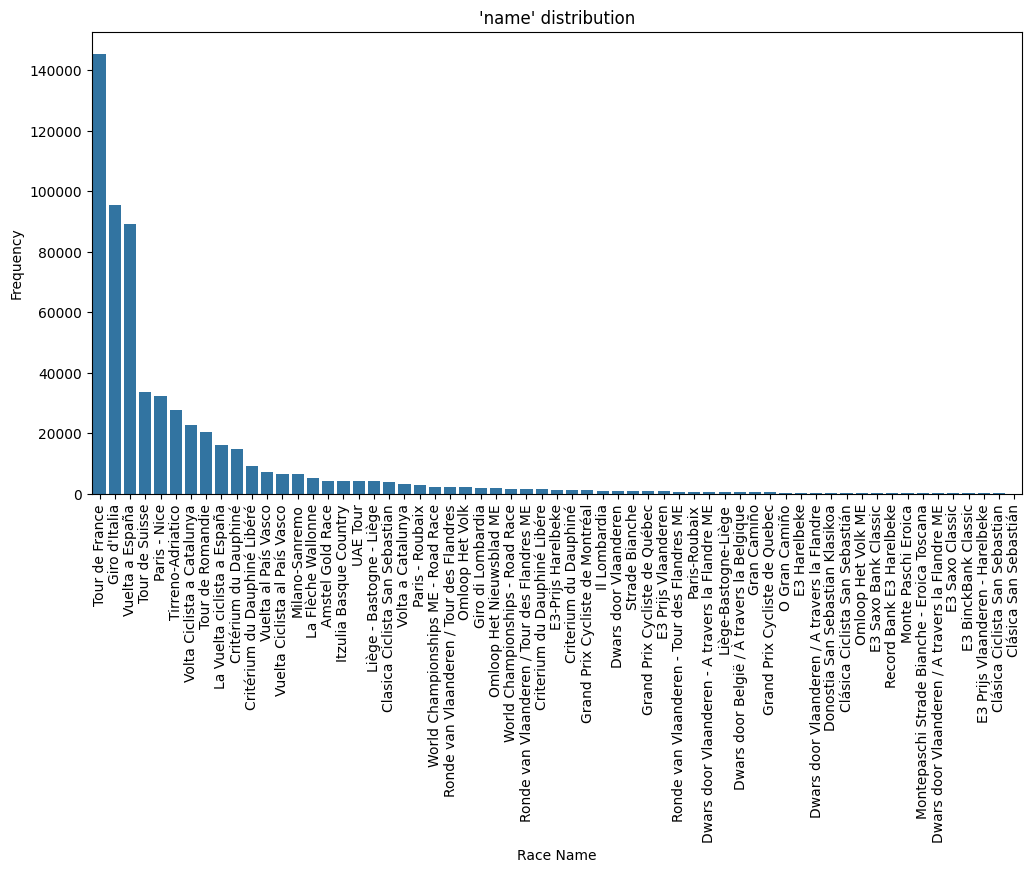

In [211]:
races_name_distribution = races['name'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=races_name_distribution.index, y=races_name_distribution.values, legend=False)
plt.title('\'name\' distribution')
plt.xlabel('Race Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

We focus on the top 10 races in the dataset that represent the 93.728% of the total values:


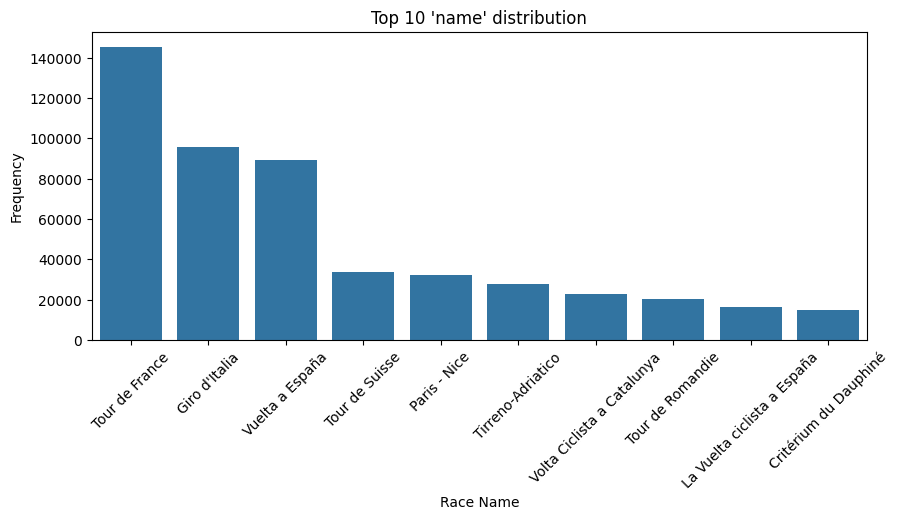

In [212]:
races_percentual = races['name'].value_counts().head(20).sum() / len(races) * 100
print(f"We focus on the top 10 races in the dataset that represent the {round(races_percentual,3)}% of the total values:")

plt.figure(figsize=(10, 4))
sns.barplot(x=races_name_distribution.head(10).index, y=races_name_distribution.head(10).values, legend=False)
plt.title('Top 10 \'name\' distribution')
plt.xlabel('Race Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### '*points*' distribution

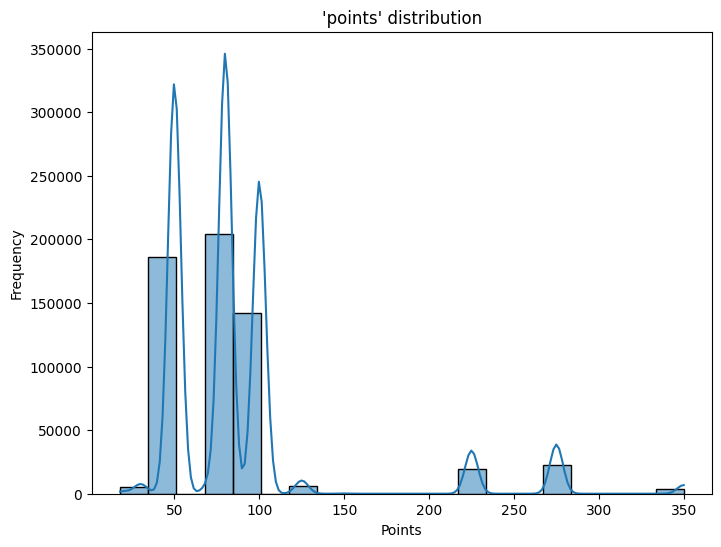

In [213]:
plt.figure(figsize=(8, 6))
sns.histplot(races['points'], bins=20, kde=True)
plt.title('\'points\' distribution')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

#### '*uci_points*' distribution

Since the UCI points are much fewer (mostly being null) they have much lower values ​​than the points because they are not assigned to every competition.

Furthermore, UCI points in general reach higher values.

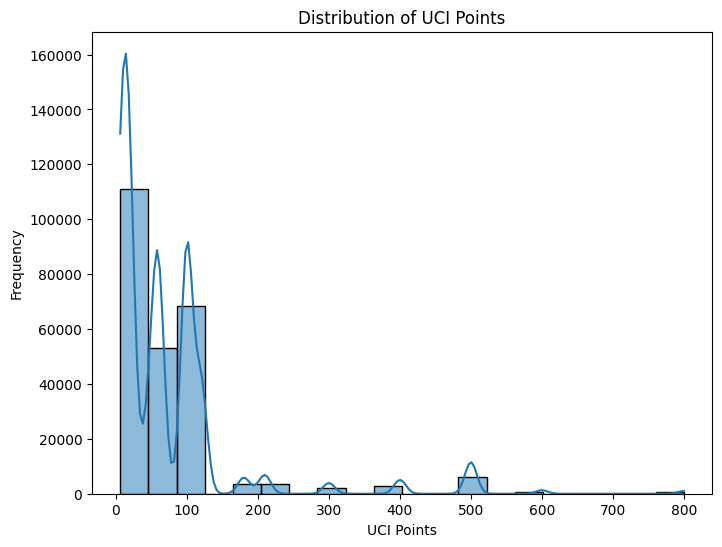

In [214]:
plt.figure(figsize=(8, 6))
sns.histplot(races['uci_points'], bins=20, kde=True)
plt.title('Distribution of UCI Points')
plt.xlabel('UCI Points')
plt.ylabel('Frequency')
plt.show()

#### '*length*' distribution

The majority of races ranges from 150 km to 200 km.

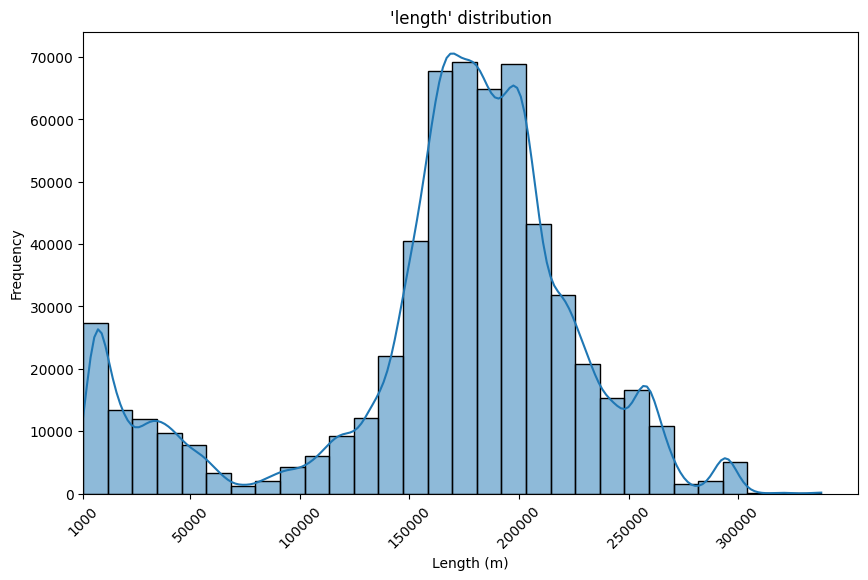

In [215]:
plt.figure(figsize=(10, 6))
sns.histplot(races['length'], bins=30, kde=True)
plt.title('\'length\' distribution')
plt.xlabel('Length (m)')
plt.ylabel('Frequency')
plt.xlim(left=1000)
plt.xticks(ticks=[1000] + list(range(50000, int(races['length'].max()) + 10000, 50000)))
plt.xticks(rotation=45)
plt.show()

#### '*climb_total*' distribution

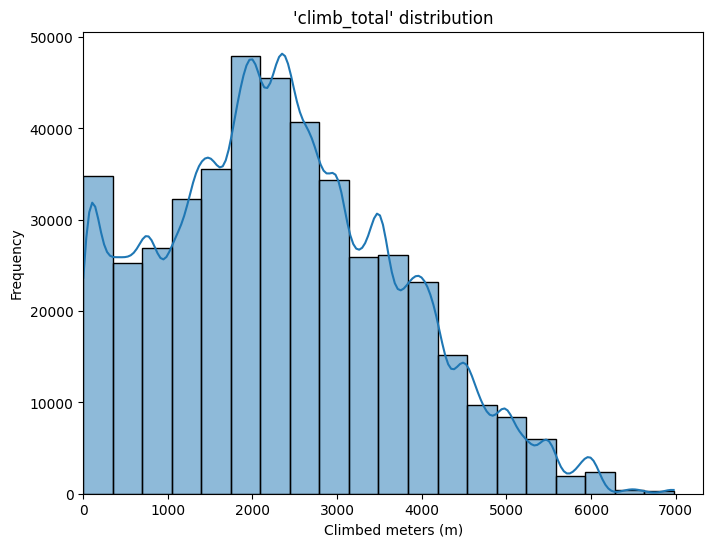

In [216]:
plt.figure(figsize=(8, 6))
sns.histplot(races['climb_total'], bins=20, kde=True)
plt.title('\'climb_total\' distribution')
plt.xlabel('Climbed meters (m)')
plt.ylabel('Frequency')
plt.xlim(left=0)
plt.show()

#### '*profile*' distribution 

The following distribution consider the profiles of the races, from flat being  ::= 1 to high mountain being ::= 5. 

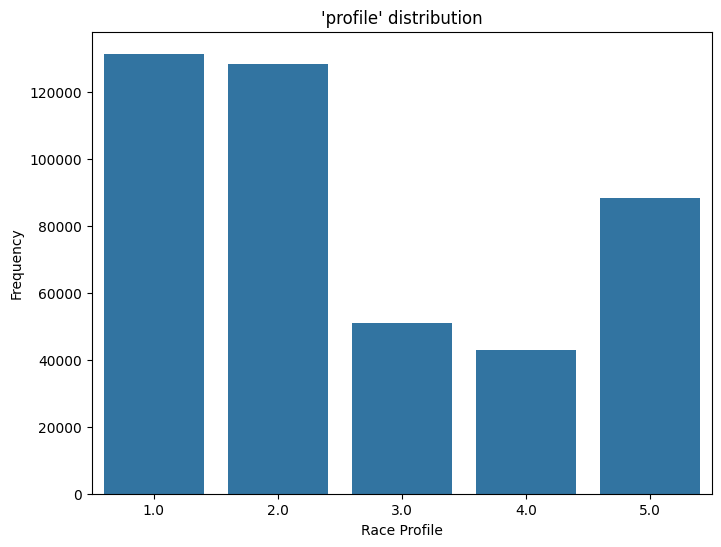

In [217]:
profile_distribution = races['profile'].value_counts().reset_index()
profile_distribution.columns = ['Profile', 'Count']

plt.figure(figsize=(8, 6))
sns.barplot(data=profile_distribution, x='Profile', y='Count', legend=False)
plt.title('\'profile\' distribution')
plt.xlabel('Race Profile')
plt.ylabel('Frequency')
plt.show()

#### '*average_temperature*' distribution

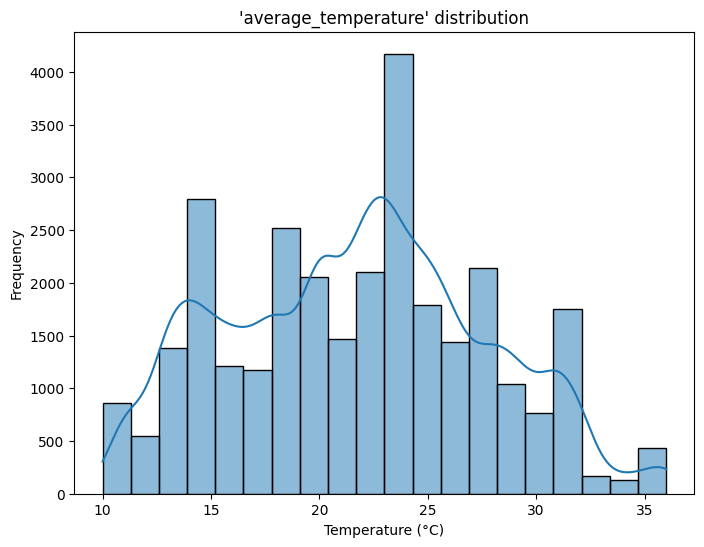

In [218]:
plt.figure(figsize=(8, 6))
sns.histplot(races['average_temperature'], bins=20, kde=True)
plt.title('\'average_temperature\' distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

#### '*date*' distribution

We considered only the year for a better representation.

All the races are between 1970 and 2023, in the dataset the majority of the races were raced after 1999. 

There is a lower value in 2020 probably due to the closure for the covid pandemic.

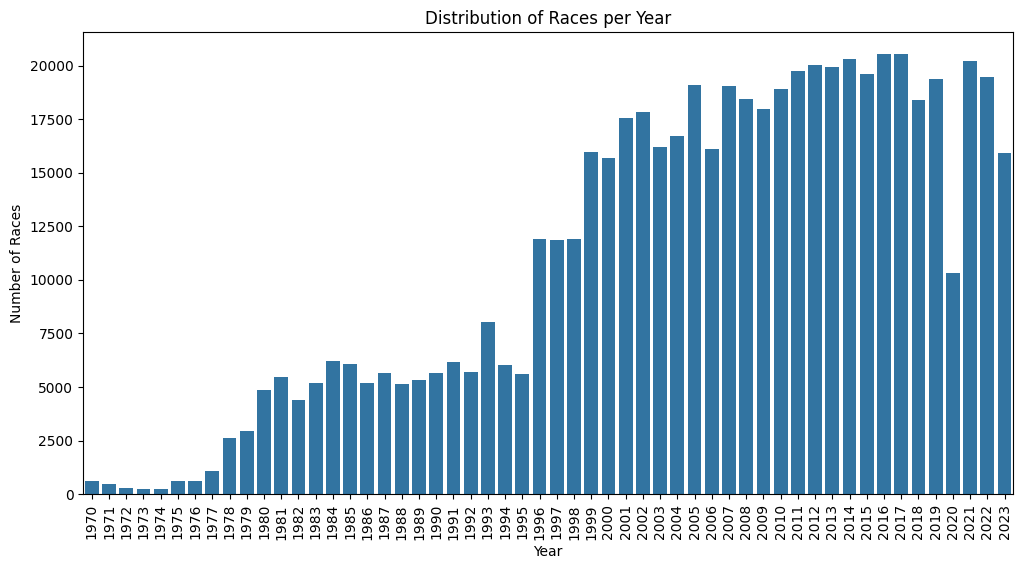

In [219]:
races_per_year = pd.to_datetime(races['date'], errors='coerce').dt.year.value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=races_per_year.index, y=races_per_year.values, legend=False)
plt.title('Distribution of Races per Year')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.xticks(rotation=90)
plt.show()


#### '*position*' distribution

Notice that 0 value stand for 1-st position.

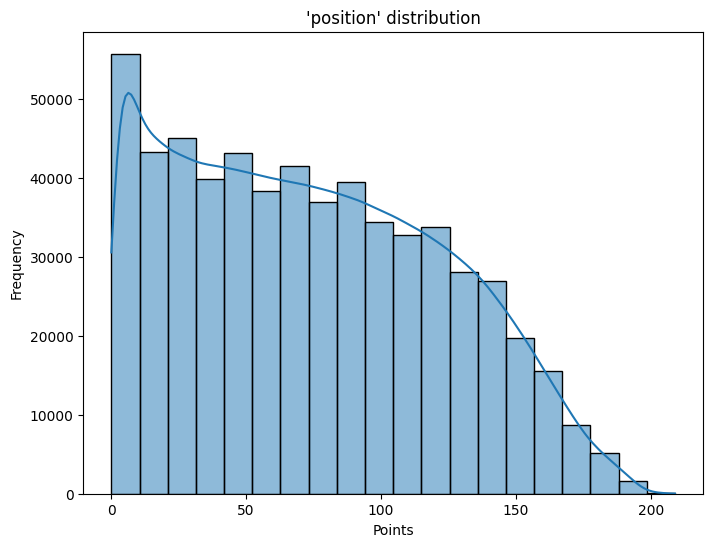

In [220]:
plt.figure(figsize=(8, 6))
sns.histplot(races['position'], bins=20, kde=True)
plt.title('\'position\' distribution')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

#### '*cyclist_age*' distribution

See how the two anomalous highlighted values (13 and 56) are negligible and therefore are not even visible by the distribution.

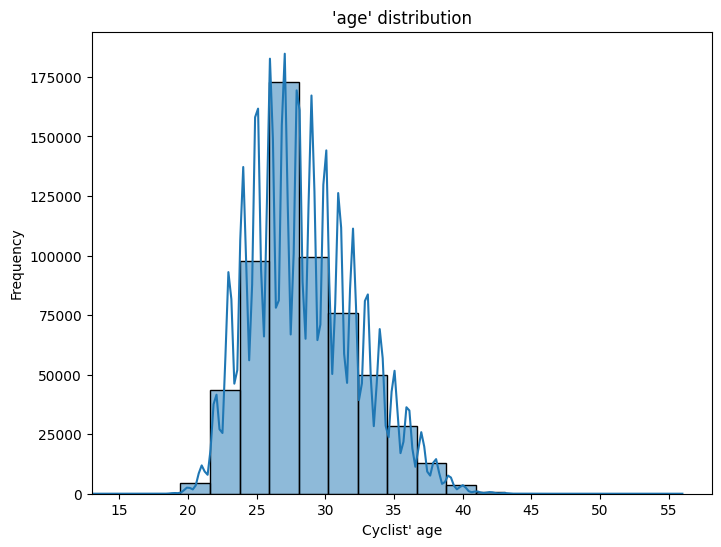

In [221]:
plt.figure(figsize=(8, 6))
sns.histplot(races['cyclist_age'], bins=20, kde=True)
plt.title('\'age\' distribution')
plt.xlabel('Cyclist\' age')
plt.ylabel('Frequency')
plt.xlim(left=13)
plt.xticks(range(15, int(races['cyclist_age'].max()), 5))
plt.show()

#### '*delta*' distribution

Being an increasing value as the position grows, the distribution shows a peak at zero, further accentuated by the multiple entries with a delta of 0 throughout the race. 

Additionally, we present the growth of delta relative to position, highlighting how cyclists tend to accumulate more delay as their position moves further from first place. We can also see that there are negative values that we can handle in outlier detection part.

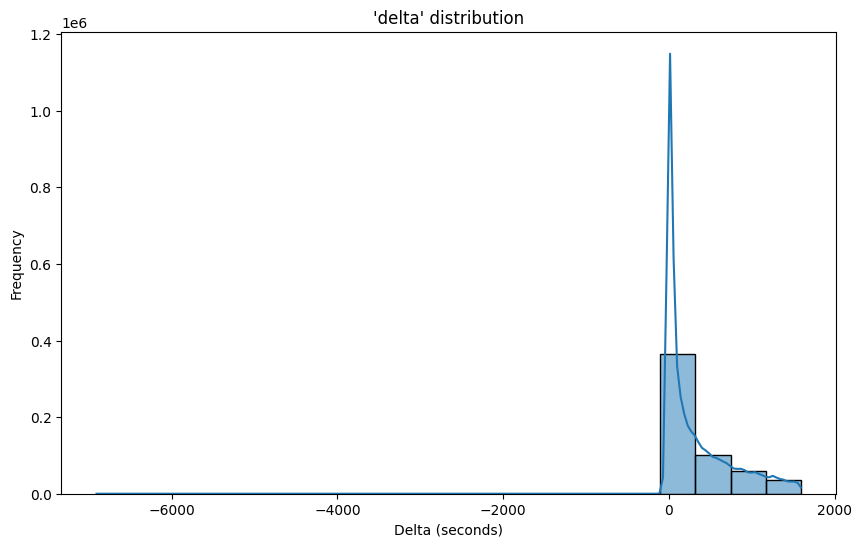

In [222]:
upper_limit = races['delta'].quantile(0.95)  # Top 5% excluded
filtered_delta = races[races['delta'] <= upper_limit]['delta']

plt.figure(figsize=(10, 6))
sns.histplot(filtered_delta, bins=20, kde=True)
plt.title('\'delta\' distribution')
plt.xlabel('Delta (seconds)')
plt.ylabel('Frequency')

plt.show()


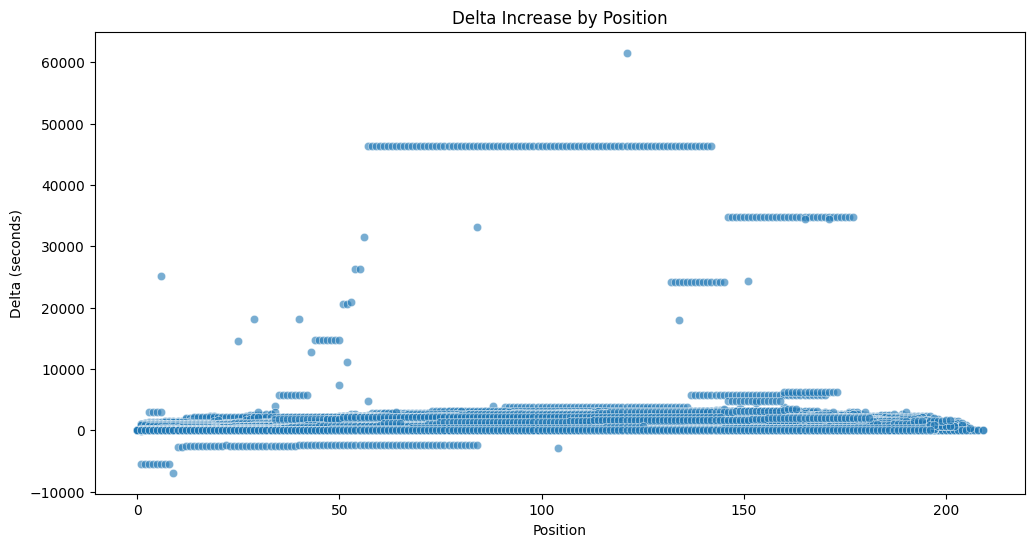

In [223]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=races, x='position', y='delta', alpha=0.6)
plt.title('Delta Increase by Position')
plt.xlabel('Position')
plt.ylabel('Delta (seconds)')
plt.show()

#### '*is_tarmac*', '*is_cobbled*', '*is_gravel*' distribution

The last thing to highlight is the distribution of races based on the surface, as you can see there are only races on tarmac which makes the three entries ​​in the dataset insignificant.

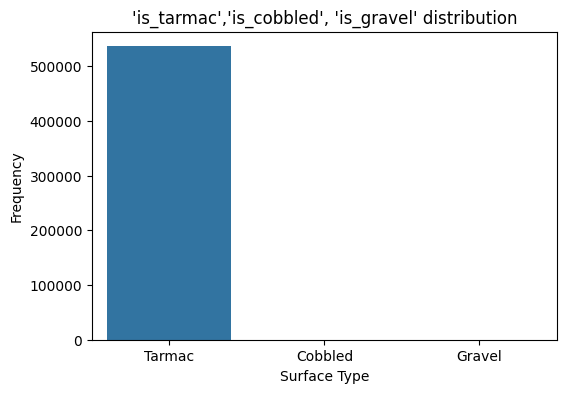

In [224]:
surface_distribution = pd.DataFrame({
    'Surface Type': ['Tarmac', 'Cobbled', 'Gravel'],
    'Count': [
        races['is_tarmac'].sum(),
        races['is_cobbled'].sum(),
        races['is_gravel'].sum()
    ]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=surface_distribution, x='Surface Type', y='Count')
plt.title('\'is_tarmac\',\'is_cobbled\', \'is_gravel\' distribution')
plt.xlabel('Surface Type')
plt.ylabel('Frequency')
plt.show()

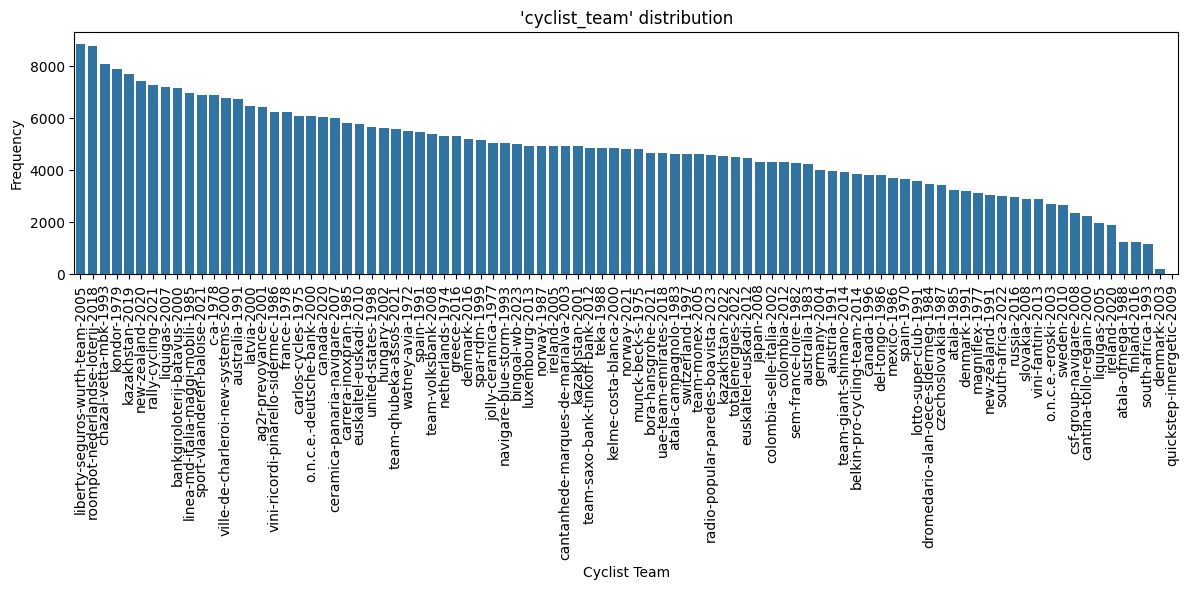

In [225]:
# Calcolo della distribuzione del conteggio
team_counts = races['cyclist_team'].value_counts().reset_index()
team_counts.columns = ['cyclist_team', 'count']

# Creazione del barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=team_counts,
    x='cyclist_team',
    y='count',
)
plt.title("'cyclist_team' distribution")
plt.xlabel('Cyclist Team')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Relationships Between Features

#### '*cyclist_team*', '*position*' and '*points*'

The goal is to evaluate the consistency of different cycling teams by analyzing the variability in their race positions and points. By studying these fluctuations, we can identify teams that deliver stable performances across events versus those with more erratic results. This analysis highlights the most dependable teams in terms of outcomes and sheds light on those whose performances are less predictable.

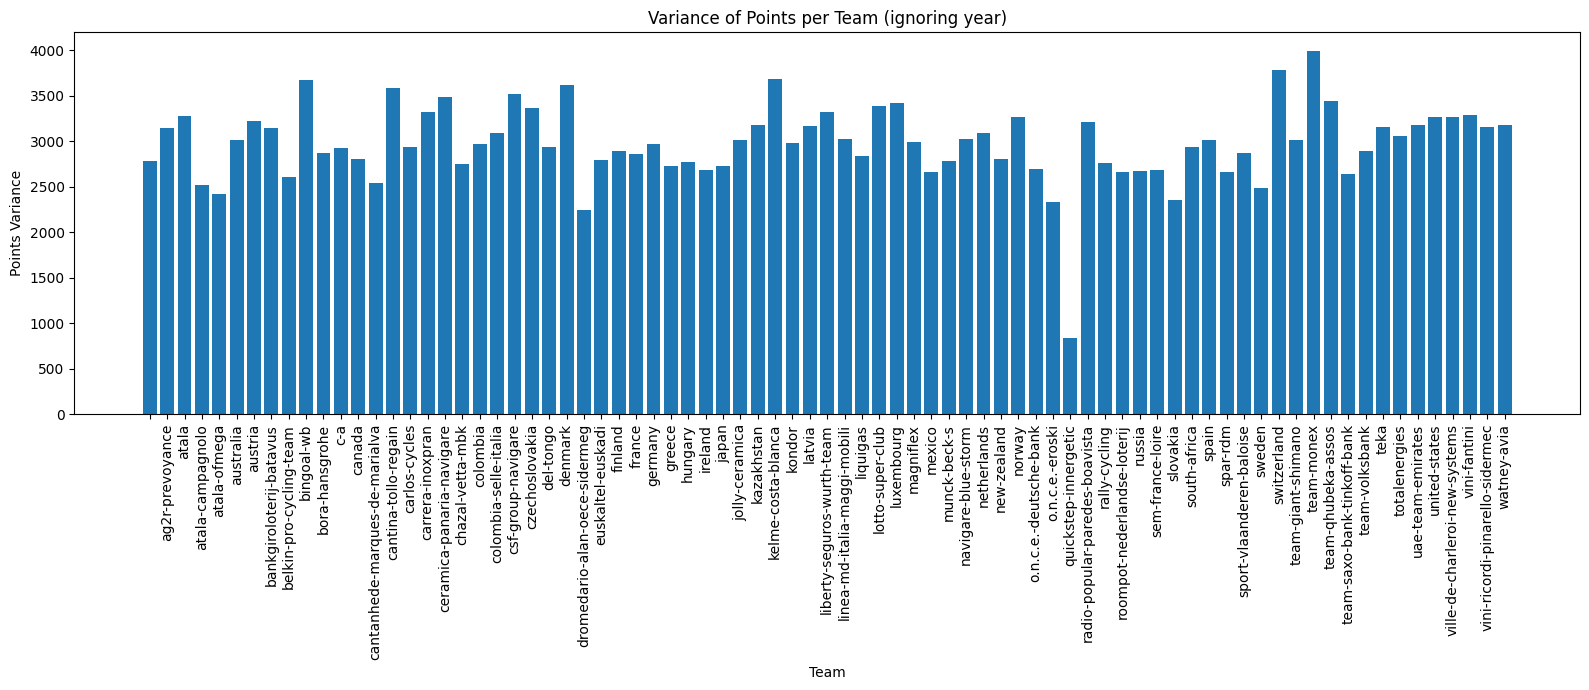

In [226]:
import re

# Merge datasets for races and cyclists
merged_data = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='inner')

# Function to extract team name without the year
def remove_year_from_team_name(team_name):
    # Extract everything before any digits (assuming the year is a 4-digit number)
    return re.sub(r'-\d{4}$', '', team_name)

# Apply function to remove the year from team names
merged_data['cyclist_team'] = merged_data['cyclist_team'].apply(lambda x: remove_year_from_team_name(str(x)) if pd.notnull(x) else '')

# Function to calculate the variance of positions and points for each team
def analyze_team_performance_variance(data):
    team_variance = {}

    # Group by team (without year)
    teams = data.groupby('cyclist_team')

    for team_name, group in teams:
        # Calculate variance for positions and UCI points
        position_variance = group['position'].var()
        points_variance = group['points'].var()

        # Add results to dictionary
        team_variance[team_name] = {
            'position_variance': position_variance,
            'points_variance': points_variance
        }

    return team_variance

# Run the analysis
team_performance_variance = analyze_team_performance_variance(merged_data)

# Create lists of teams and variances
teams = list(team_performance_variance.keys())
position_variances = [v['position_variance'] for v in team_performance_variance.values()]
points_variances = [v['points_variance'] for v in team_performance_variance.values()]

# Plot variance of points per team
plt.figure(figsize=(16, 7))
plt.bar(teams, points_variances)
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.ylabel('Points Variance')
plt.title('Variance of Points per Team (ignoring year)')
plt.tight_layout()
plt.show()


#### '*cyclist_age*', '*position*' (average), '*points*'

This analysis investigates the correlation between a cyclist's age and their race performance, represented by their average position. By grouping race data by age, we calculate the average position and points for each age group, uncovering trends such as whether younger or older cyclists perform better in terms of ranking. Annotating the chart with the number of cyclists per age group provides context to the averages and helps identify outliers or particularly common ages among competitors. This visualization offers valuable insights into how age and experience influence performance in competitive cycling.

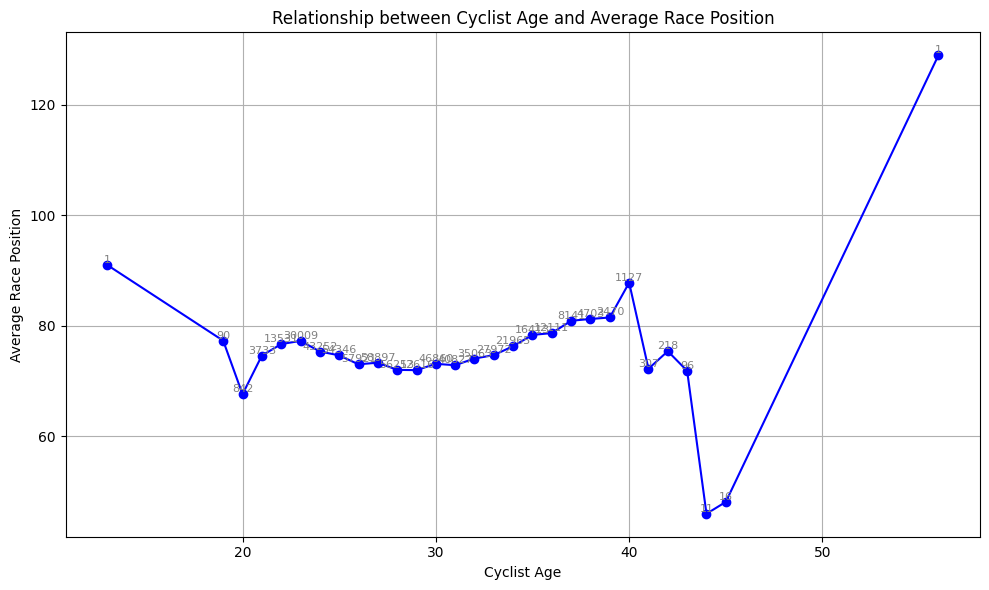

In [227]:
# Merge datasets based on cyclist URL and race identifier
merged_data1 = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='inner')

# Calculate the average age of cyclists during races
merged_data1['calculated_age'] = merged_data1['cyclist_age'].fillna(
    merged_data1['date'].apply(lambda x: int(x[:4])) - merged_data1['birth_year']
)

# Group data by age and calculate the average position, points, and count of cyclists
grouped_by_age = merged_data1.groupby('calculated_age').agg(
    avg_position=('position', 'mean'),
    avg_points=('points', 'mean'),
    count=('position', 'size')  # Count of elements per age
).reset_index()

# Plot: Relationship between age and average race position with count annotation
plt.figure(figsize=(10, 6))
plt.plot(grouped_by_age['calculated_age'], grouped_by_age['avg_position'], marker='o', color='b')
plt.xlabel('Cyclist Age')
plt.ylabel('Average Race Position')
plt.title('Relationship between Cyclist Age and Average Race Position')

# Annotate the count of elements analyzed per age
for i, row in grouped_by_age.iterrows():
    plt.text(row['calculated_age'], row['avg_position'], f"{int(row['count'])}", 
             ha='center', va='bottom', fontsize=8, color='gray')

plt.grid(True)
plt.tight_layout()
plt.show()


#### '*weight*', '*height*' and '*position*'

This visualization explores the relationship between cyclists' weight, height, and their race positions. By varying color and size to represent race position, we can quickly detect correlations between physical attributes (e.g., height or weight) and ranking. This analysis provides insights into whether specific physical profiles offer competitive advantages in professional cycling.

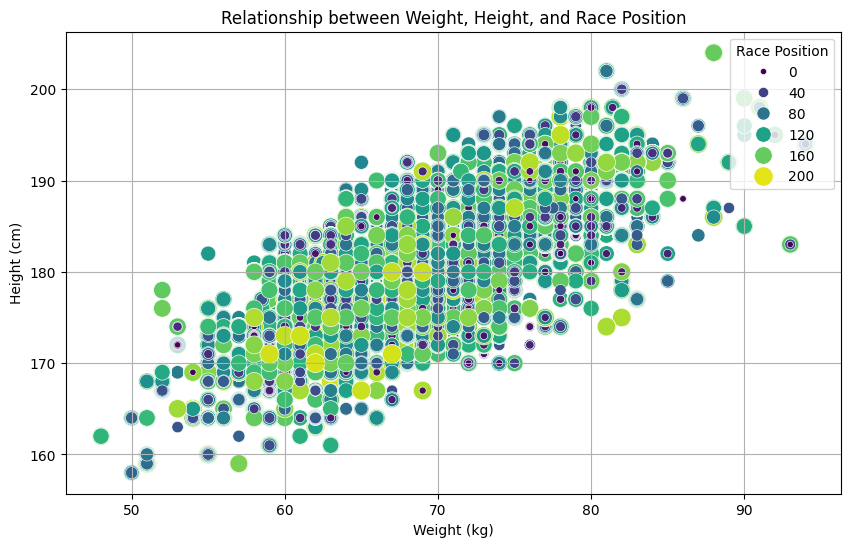

In [228]:
# Merge datasets based on cyclist URL and race identifier
merged_data2 = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='inner')

# Visualize the relationship between weight, height, and race position
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data2, x='weight', y='height', hue='position', size='position', sizes=(20, 200), palette='viridis')
plt.title('Relationship between Weight, Height, and Race Position')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')
plt.legend(title='Race Position', loc='upper right')
plt.grid(True)
plt.show()


This code examines the relationship between weight, height, and race position using a 3D scatter plot. By merging cyclist and race data, the plot visually displays correlations between physical attributes and performance, with race positions color-coded to highlight patterns.

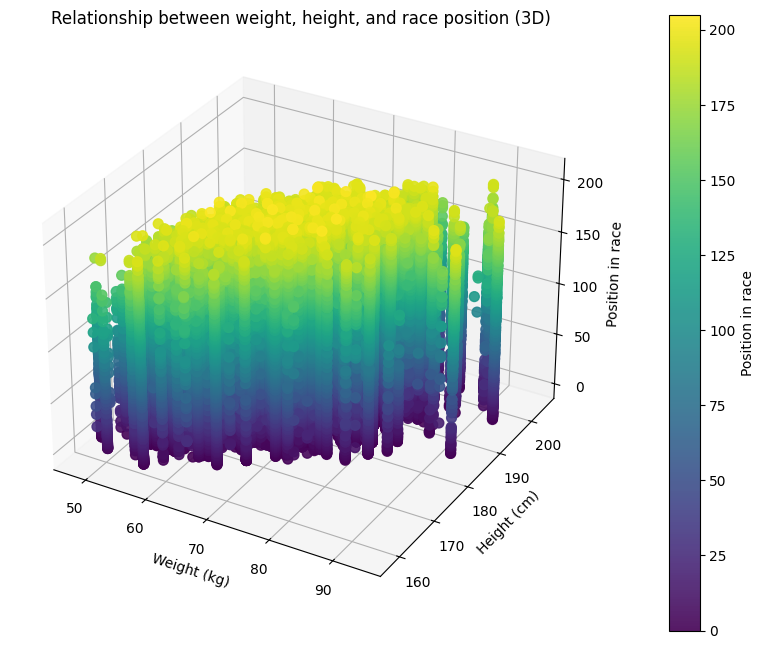

In [229]:
# Merge datasets on 'cyclist' and '_url' columns with an inner join
merged_data3 = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='inner')

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with weight, height, and position
scatter = ax.scatter(merged_data3['weight'], merged_data3['height'], merged_data3['position'],
                     c=merged_data3['position'], cmap='viridis', s=50, alpha=0.9)

# Add axis labels
ax.set_xlabel('Weight (kg)')
ax.set_ylabel('Height (cm)')
ax.set_zlabel('Position in race')

# Add legend and color bar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Position in race')

plt.title('Relationship between weight, height, and race position (3D)')
plt.show()


This code focuses on identifying the physical traits of top-performing cyclists by filtering the dataset for those finishing in the top three positions. After removing rows with missing values for weight, height, or position, it calculates descriptive statistics for these attributes. These statistics provide insights into the common physical characteristics of cyclists who achieve podium finishes.

In [230]:
# Merge datasets based on cyclist URL and race identifier
merged_data4 = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='inner')

# Remove rows with missing data for weight, height, or position
merged_data_cleaned = merged_data4.dropna(subset=['weight', 'height', 'position'])

# Define success as cyclists finishing in the top 3 positions
successful_cyclists = merged_data_cleaned[merged_data_cleaned['position'] <= 3]

# Calculate descriptive statistics for weight and height of successful cyclists
weight_stats = successful_cyclists['weight'].describe()
height_stats = successful_cyclists['height'].describe()

# Print the weight statistics of successful cyclists
print("Weight statistics of successful cyclists:")
print(weight_stats)

# Print the height statistics of successful cyclists
print("\nHeight statistics of successful cyclists:")
print(height_stats)


Weight statistics of successful cyclists:
count    16567.000000
mean        68.771172
std          6.300266
min         48.000000
25%         64.000000
50%         69.000000
75%         73.000000
max         94.000000
Name: weight, dtype: float64

Height statistics of successful cyclists:
count    16567.000000
mean       178.621476
std          5.783193
min        159.000000
25%        175.000000
50%        178.000000
75%        183.000000
max        199.000000
Name: height, dtype: float64


#### '*weight*', '*height*', '*position*' and '*nationality*'

This code analyzes how weight and height categories relate to race positions, with a particular focus on nationality. Athletes are categorized into five bins each for weight (ranging from "Low" to "High") and height (from "Short" to "Tall").
The visualization plots race position against combined weight and height categories, highlighting patterns in physical characteristics and performance. By using color to represent nationality, the chart underscores potential regional or cultural trends in competitive cycling, revealing how physical profiles and nationality might jointly influence outcomes.

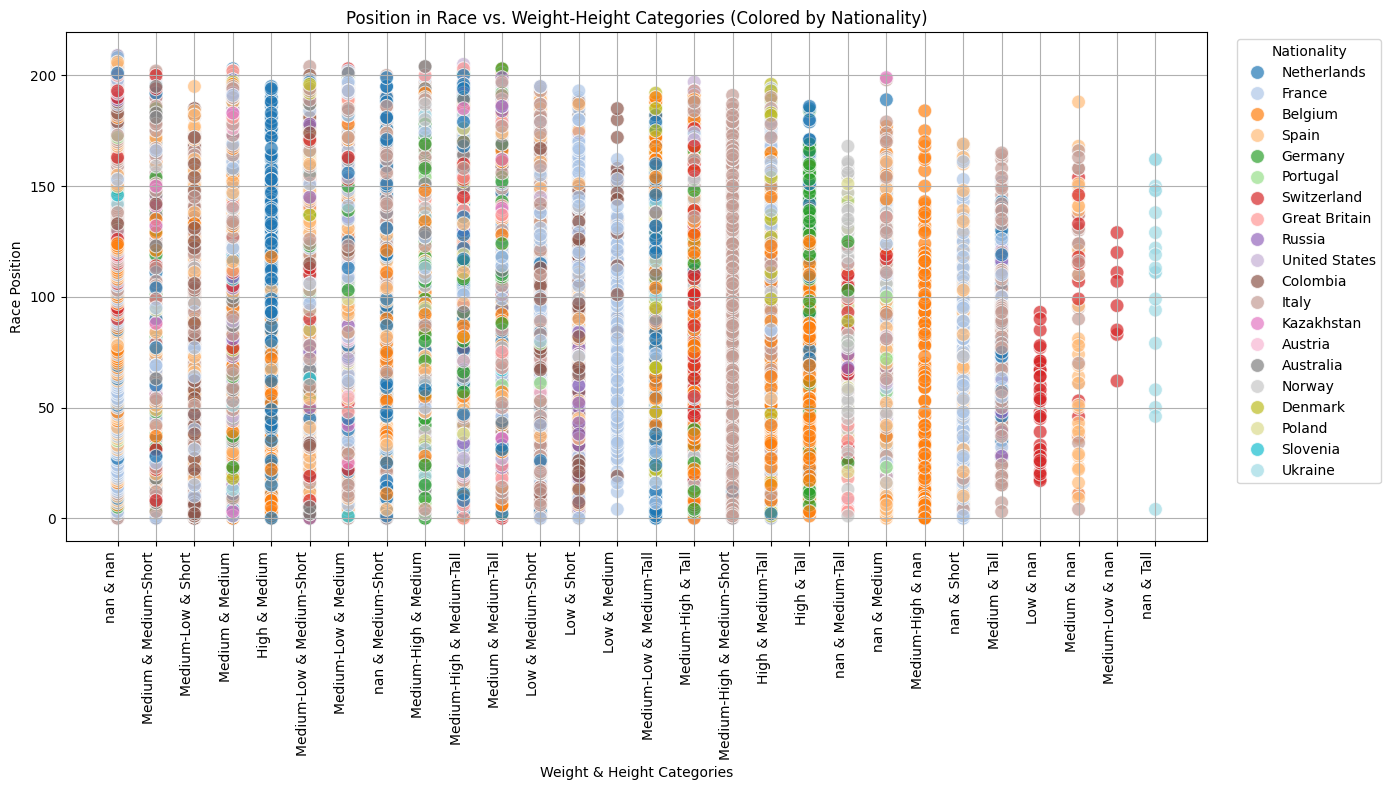

In [231]:
# Create bins for weight and height
merged_data1['weight_bins'] = pd.cut(merged_data1['weight'], bins=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])
merged_data1['height_bins'] = pd.cut(merged_data1['height'], bins=5, labels=['Short', 'Medium-Short', 'Medium', 'Medium-Tall', 'Tall'])

# Create a variable for combinations of weight and height categories
merged_data1['weight_height_comb'] = merged_data1['weight_bins'].astype(str) + " & " + merged_data1['height_bins'].astype(str)

# Get the top 10 nationalities by count
top_nationalities = merged_data1['nationality'].value_counts().head(20).index

# Filter data for the top nationalities
filtered_data = merged_data1[merged_data1['nationality'].isin(top_nationalities)]


# Configure the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=filtered_data,
    x='weight_height_comb',
    y='position',
    hue='nationality',
    palette='tab20',
    s=100,
    alpha=0.7
)

# Set axis labels and title
plt.title('Position in Race vs. Weight-Height Categories (Colored by Nationality)')
plt.xlabel('Weight & Height Categories')
plt.ylabel('Race Position')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Nationality', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add grid and show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

#### '*length*', '*points*' and '*climb_total*'

This analysis examines the relationship between race length, total points, and elevation gain across different races. The data is first cleaned to ensure each stage is represented by a single entry. Races are grouped by name, stage details are excluded, and lengths are converted to kilometers for uniformity. Total points and elevation gain are aggregated to summarize race characteristics.
A scatter plot visualizes the relationship, plotting race length against total points, with color indicating total elevation gain. This approach reveals how these three factors interact, offering a comprehensive view of race dynamics.

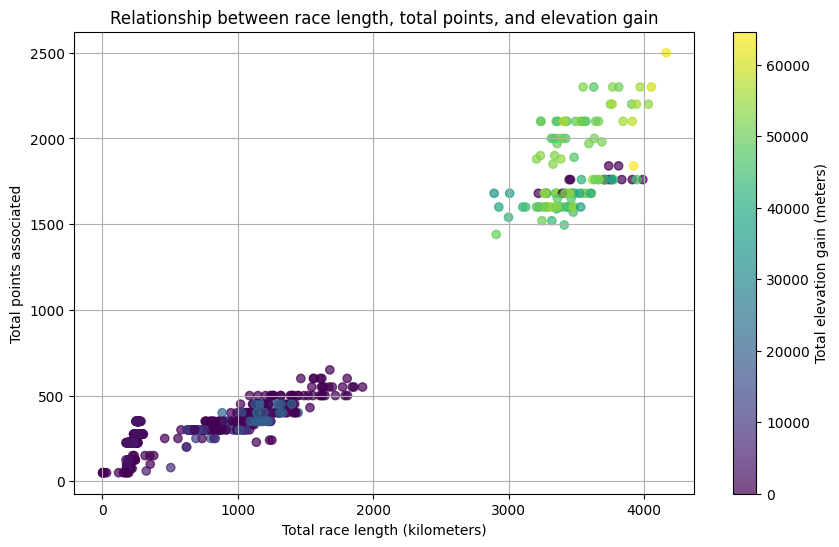

In [232]:
# Filter data to remove duplicates based on '_url' (only one row per race stage)
races_unique = races.drop_duplicates(subset='_url').copy()

# Separate race name and remove "stage" details
races_unique.loc[:, 'race_group'] = races_unique['_url'].apply(lambda x: '/'.join(x.split('/')[:-1]))  # Remove stage part

# Convert length to kilometers (if values are in meters)
races_unique.loc[:, 'length_km'] = races_unique['length'] / 1000

# Group by race (country/year) and calculate the sum of "length", "points", and "climb_total" for each race
grouped_races = races_unique.groupby('race_group').agg({'length_km': 'sum', 'points': 'sum', 'climb_total': 'sum'}).reset_index()

# Create plot with "climb_total" represented by the color of the points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(grouped_races['length_km'], grouped_races['points'], 
                      c=grouped_races['climb_total'], cmap='viridis', alpha=0.7)
plt.title('Relationship between race length, total points, and elevation gain')
plt.xlabel('Total race length (kilometers)')
plt.ylabel('Total points associated')
plt.colorbar(scatter, label='Total elevation gain (meters)')
plt.grid(True)
plt.show()

This is only to better analize what happens in the gap wee see above.

In [233]:
# Filter data to remove duplicates based on '_url' (keep only one row per race stage)
races_unique = races.drop_duplicates(subset='_url').copy()

# Separate the race name and remove the "stage" part
races_unique['race_group'] = races_unique['_url'].apply(lambda x: '/'.join(x.split('/')[:-1]))

# Convert length to kilometers (if values are in meters)
races_unique['length_km'] = races_unique['length'] / 1000

# Group by race (country/year) and calculate the total length for each race
grouped_races = races_unique.groupby('race_group').agg({'length_km': 'sum', 'points': 'sum'}).reset_index()

# Filter races with a total length between 2000 km and 3000 km
filtered_races = grouped_races[(grouped_races['length_km'] >= 2000) & (grouped_races['length_km'] <= 3000)]

# Print the filtered races
print(filtered_races)



               race_group  length_km  points
974  vuelta-a-espana/2000     2892.9  1680.0
977  vuelta-a-espana/2003     2927.4  1600.0
978  vuelta-a-espana/2004     2998.9  1540.0
994  vuelta-a-espana/2020     2908.0  1440.0


#### '*position*' (average) and '*nationality*'

This analysis explores how average race position varies by cyclist nationality. By merging datasets, we integrate cyclists' nationalities with their race positions into a single table. We then calculate the average race position for each nationality and determine the number of cyclists representing each country in races.
The visualization uses bar colors to indicate the number of race records per nationality, providing additional context to the average positions and highlighting trends across different countries.

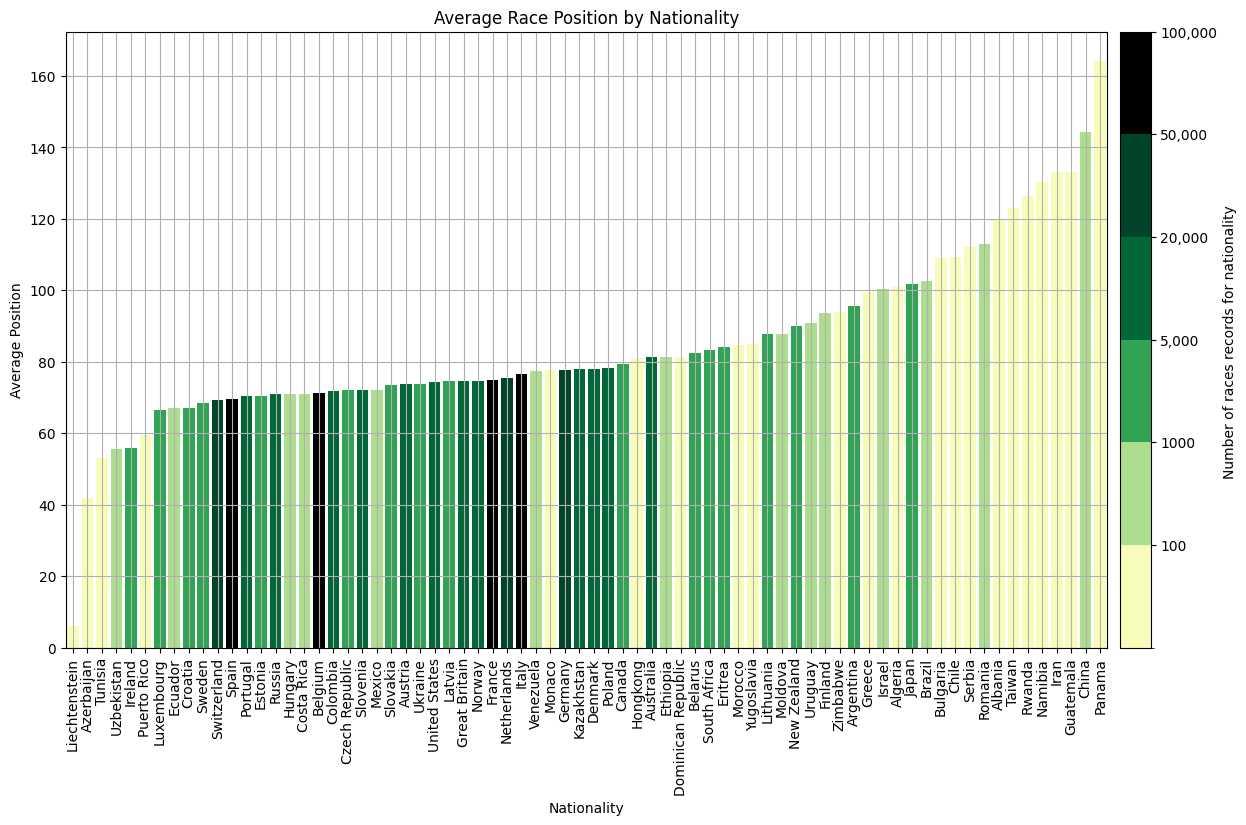

In [234]:
# Merge the races and cyclists datasets to have both nationality and position in the same table
merged_data = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='inner')

# Calculate the average race position and count of cyclists for each nationality
average_position = merged_data.groupby('nationality').agg({'position': 'mean', 'cyclist': 'count'}).reset_index()
average_position = average_position.rename(columns={'cyclist': 'num_cyclists'})

# Sort values to make the plot more readable
average_position = average_position.sort_values(by='position')

# Define bins and corresponding colors
bins = [0, 100, 1000, 5000, 20000, 50000,100000]
colors = ['#f7fcb9', '#addd8e', '#31a354', '#006837', '#004529','#000000']  # Custom colors from light to dark

# Create a function to assign colors based on the number of cyclists
def get_color(num):
    for i in range(len(bins) - 1):
        if bins[i] < num <= bins[i + 1]:
            return colors[i]
    return colors[-1]  # Return the last color if it exceeds the last bin

# Assign colors based on the number of cyclists
average_position['color'] = average_position['num_cyclists'].apply(get_color)

# Plot the average race position by nationality
plt.figure(figsize=(16, 8))
bars = sns.barplot(data=average_position, x='nationality', y='position')

# Set colors based on the number of cyclists
for index, bar in enumerate(bars.patches):
    bar.set_facecolor(average_position['color'].iloc[index])

# Set the plot title and labels
plt.title('Average Race Position by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Average Position')

# Rotate nationality labels on the x-axis for better readability
plt.xticks(rotation=90)
plt.grid(True)

# Create a color bar manually
cmap = plt.cm.colors.ListedColormap(colors)
bounds = bins
norm = plt.cm.colors.BoundaryNorm(boundaries=bounds, ncolors=len(colors))

# Create the color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=bars, pad=0.01)
cbar.set_label("Number of races records for nationality ")

# Set the ticks and labels for the color bar
cbar.set_ticks([100, 1000, 5000, 20000, 50000,100000])
cbar.set_ticklabels(['100', '1000', '5,000', '20,000', '50,000','100,000'])

plt.show()


This code analyzes how weight and height categories relate to race positions, with a particular focus on nationality. Athletes are categorized into five bins each for weight (ranging from "Low" to "High") and height (from "Short" to "Tall").
The visualization plots race position against combined weight and height categories, highlighting patterns in physical characteristics and performance. By using color to represent nationality, the chart underscores potential regional or cultural trends in competitive cycling, revealing how physical profiles and nationality might jointly influence outcomes.

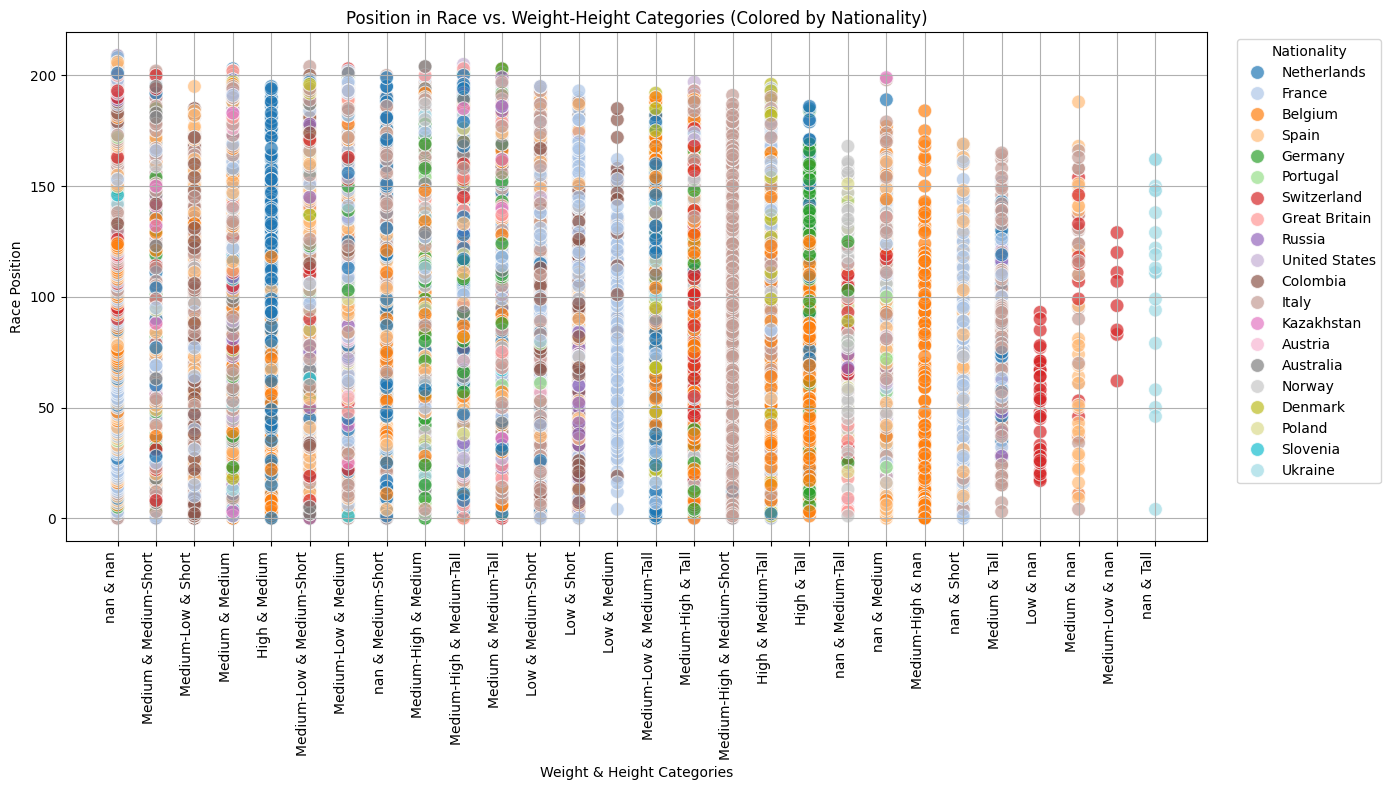

In [235]:
# Create bins for weight and height
merged_data1['weight_bins'] = pd.cut(merged_data1['weight'], bins=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])
merged_data1['height_bins'] = pd.cut(merged_data1['height'], bins=5, labels=['Short', 'Medium-Short', 'Medium', 'Medium-Tall', 'Tall'])

# Create a variable for combinations of weight and height categories
merged_data1['weight_height_comb'] = merged_data1['weight_bins'].astype(str) + " & " + merged_data1['height_bins'].astype(str)

# Get the top 10 nationalities by count
top_nationalities = merged_data1['nationality'].value_counts().head(20).index

# Filter data for the top nationalities
filtered_data = merged_data1[merged_data1['nationality'].isin(top_nationalities)]


# Configure the scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=filtered_data,
    x='weight_height_comb',
    y='position',
    hue='nationality',
    palette='tab20',
    s=100,
    alpha=0.7
)

# Set axis labels and title
plt.title('Position in Race vs. Weight-Height Categories (Colored by Nationality)')
plt.xlabel('Weight & Height Categories')
plt.ylabel('Race Position')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Nationality', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add grid and show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

#### '*points*' and '*uci_points*'

This code examines the distribution of races that award UCI points versus those that do not. A new column categorizes each race as either "Awards UCI Points" or "Does Not Award UCI Points," capturing an important distinction that impacts race prestige and competitiveness.
A bar plot visualizes the number of races in each category, enabling a straightforward comparison. This analysis provides insights into the prevalence of point-awarding events, shedding light on the structure and competitive hierarchy of cycling races. Color distinctions enhance visual clarity, emphasizing differences between the two categories.

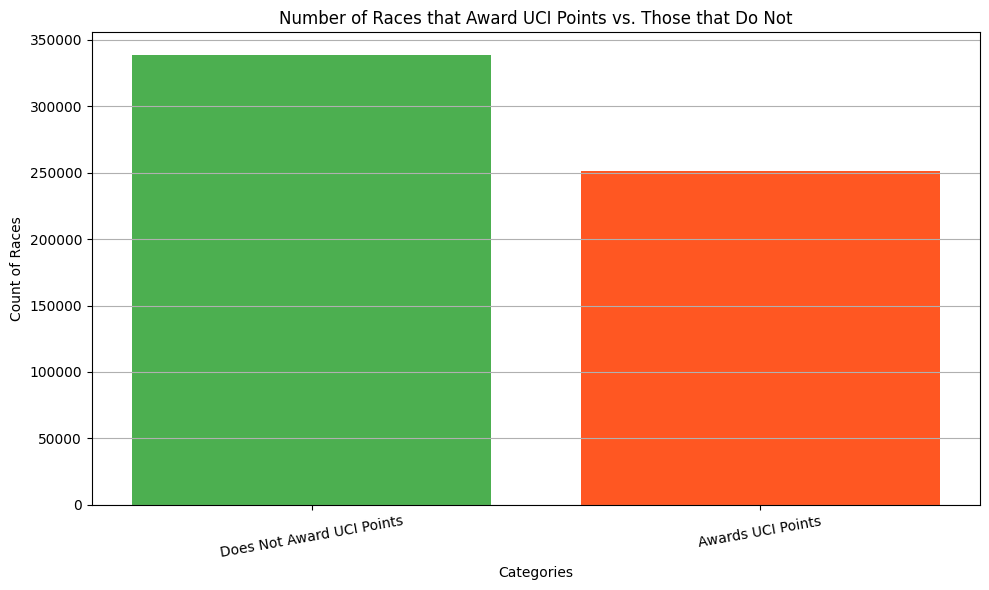

In [236]:
# Create a new column to indicate whether the race awards UCI points
races['awards_uci_points'] = races['uci_points'].apply(lambda x: 'Awards UCI Points' if x > 0 else 'Does Not Award UCI Points')

# Count the number of races in each category
uci_points_count = races['awards_uci_points'].value_counts()

# Create a bar plot to display the counts
plt.figure(figsize=(10, 6))
plt.bar(uci_points_count.index, uci_points_count.values, color=['#4CAF50', '#FF5722'])
plt.title('Number of Races that Award UCI Points vs. Those that Do Not')
plt.xlabel('Categories')
plt.ylabel('Count of Races')
plt.xticks(rotation=10)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


#### '*profile*', '*length*', '*startlist_quality*', '*points*' and '*uci_points*'

This analysis aims to understand how race attributes—such as profile, length, and startlist quality—influence cyclist performance, measured by points and UCI points. By exploring these relationships, we can determine which factors most significantly affect race outcomes. Scatter plots provide a visual representation of these dynamics, offering insights into the interplay between race characteristics and performance results.

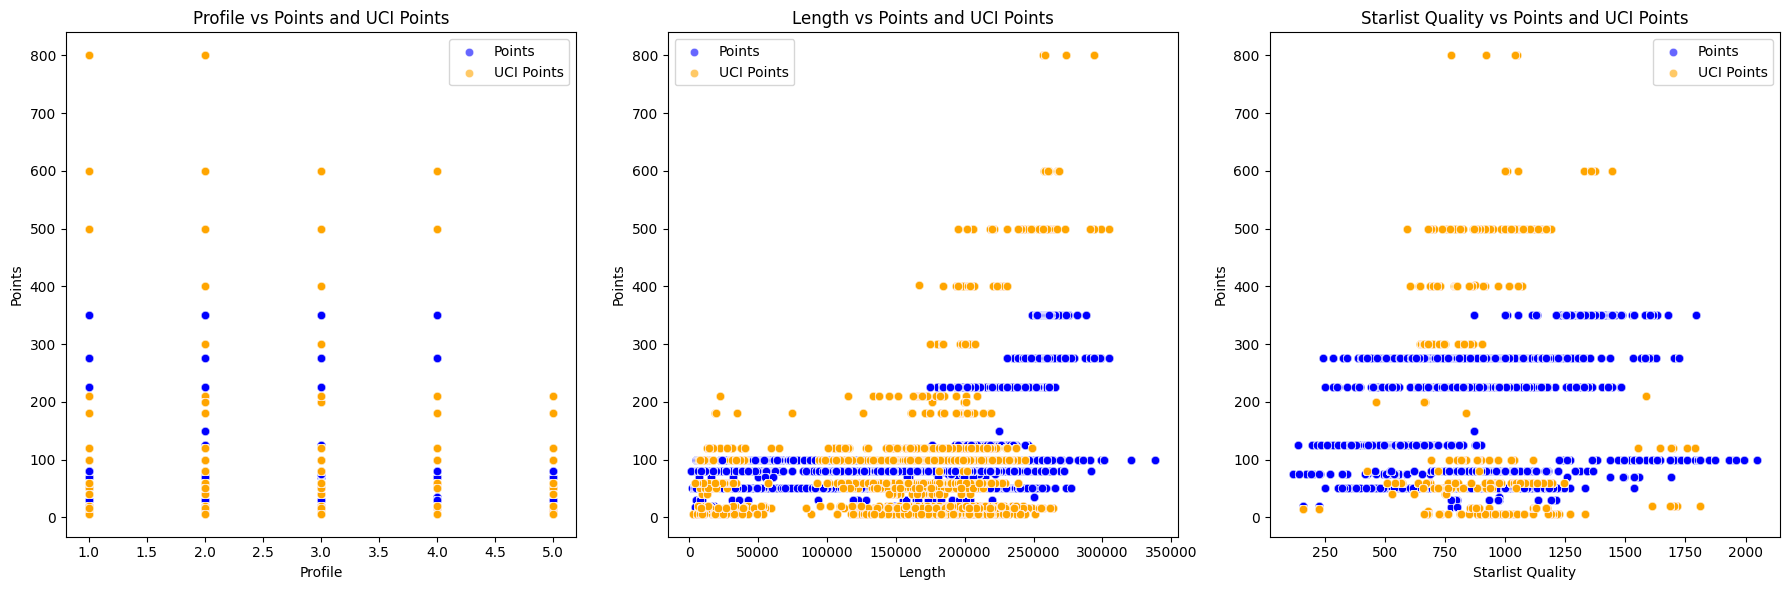

In [237]:

# Assuming merged_data5 is already created and contains the necessary columns
merged_data5 = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='inner')

# Set the figure size for better visualization
plt.figure(figsize=(18, 6))

# Scatter plot for Profile vs Points and UCI Points
plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_data5, x='profile', y='points', color='blue', label='Points', alpha=0.6)
sns.scatterplot(data=merged_data5, x='profile', y='uci_points', color='orange', label='UCI Points', alpha=0.6)
plt.title('Profile vs Points and UCI Points')
plt.xlabel('Profile')
plt.ylabel('Points')
plt.legend()

# Scatter plot for Length vs Points and UCI Points
plt.subplot(1, 3, 2)
sns.scatterplot(data=merged_data5, x='length', y='points', color='blue', label='Points', alpha=0.6)
sns.scatterplot(data=merged_data5, x='length', y='uci_points', color='orange', label='UCI Points', alpha=0.6)
plt.title('Length vs Points and UCI Points')
plt.xlabel('Length')
plt.ylabel('Points')
plt.legend()

# Scatter plot for Starlist Quality vs Points and UCI Points
plt.subplot(1, 3, 3)
sns.scatterplot(data=merged_data5, x='startlist_quality', y='points', color='blue', label='Points', alpha=0.6)
sns.scatterplot(data=merged_data5, x='startlist_quality', y='uci_points', color='orange', label='UCI Points', alpha=0.6)
plt.title('Starlist Quality vs Points and UCI Points')
plt.xlabel('Starlist Quality')
plt.ylabel('Points')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
